### Clusterização dos clientes da venda: 

Realizar com as seguintes colunas, para conseguiur encontrar o perfil dos clientes mais valiosos:
        'Tipo de Cliente', 'Histórico de Aluguel (se aplicável)', 'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)','Preço de Venda (R$)'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.cluster import KMeans

In [4]:
db_vendas = pd.read_csv('historico_vendas.csv')

### Limpeza de dados

In [5]:
db_alterado = db_vendas.copy()

In [6]:
db_alterado.dropna(how='all', inplace=True)

db_alterado['Data da Venda'].dtype #ou seja eh uma string 

data_venda = db_alterado['Data da Venda']


def convert_to_month_year(date_str):
    if isinstance(date_str, str):
        # First, check if the date is already in the yyyy-mm-dd format
        if re.match(r'\d{4}-\d{2}-\d{2}', date_str):
            return pd.to_datetime(date_str).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Check for the dd/mm/yyyy format
        elif re.match(r'\d{2}/\d{2}/\d{4}', date_str):
            return pd.to_datetime(date_str, dayfirst=True).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Handle verbose format like '03 de August de 2023'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            # Mapping Portuguese/English month names to their corresponding numbers
            months_mapping = {
                'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
                'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
                'november': '11', 'december': '12',
                'janeiro': '01', 'fevereiro': '02', 'março': '03', 'abril': '04', 'maio': '05',
                'junho': '06', 'julho': '07', 'agosto': '08', 'setembro': '09', 'outubro': '10',
                'novembro': '11', 'dezembro': '12'
            }
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                # Return in Year-Month format
                return f'{year}-{month_num}'


db_alterado['Data da Venda'] = data_venda.apply(convert_to_month_year)


db_alterado['Ano de Fabricação do Carro'] = db_alterado['Ano de Fabricação do Carro'].astype(int)


db_alterado = db_alterado.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

db_alterado = db_alterado.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)



db_alterado['Tipo de Combustível'] = db_alterado['Tipo de Combustível'].replace({
    'elétrico': 'eletrico',
    'híbrido': 'hibrido'
})

db_alterado['Forma de Pagamento'] = db_alterado['Forma de Pagamento'].replace({
    'cartao de crédito': 'cartao de credito',
    'cartão de credito': 'cartao de credito',
    'cartão de crédito': 'cartao de credito',
    'transferência bancária' : 'transferencia bancaria'
})

db_alterado['Histórico de Aluguel (se aplicável)'] = db_alterado['Histórico de Aluguel (se aplicável)'].replace({
    'n': 'nao',
    'não': 'nao'
})

db_alterado['Cancelamento da Venda'] = db_alterado['Cancelamento da Venda'].replace({
    'n': 'nao',
    'não':'nao'
})

db_alterado['Motivo do Cancelamento (se aplicável)'] = db_alterado['Motivo do Cancelamento (se aplicável)'].replace({
    'problema na documentaçao': 'problema na documentação'
})

#db_alterado["Cancelamento da Venda"] = db_alterado.loc[db_alterado["Cancelamento da Venda"] != "sim", "Cancelamento da Venda"]

#db_alterado.dropna(subset=["Cancelamento da Venda"], inplace=True)


In [7]:
db_alterado

,ID do Cliente,Tipo de Cliente,Data da Venda,ID do Carro Vendido,Marca do Carro,Ano de Fabricação do Carro,Quilometragem do Carro no Momento da Venda,Tipo de Combustível,Tipo de Transmissão,Preço de Venda (R$),Forma de Pagamento,Status do Pagamento,Histórico de Aluguel (se aplicável),ID do Contrato de Aluguel Anterior (se aplicável),Desconto para Ex-cliente de Aluguel (%),Cancelamento da Venda,Motivo do Cancelamento (se aplicável),Coerente
0,67593.0,b2c,2023-05,516713.0,volkswagen,2022,37656.0,hibrido,automática,135375.00,transferencia bancaria,completo,nao,NaN,0.0,nao,NaN,True
1,88684.0,b2b,2022-03,562471.0,chevrolet,2013,214637.0,gasolina,automática,72948.61,financiamento,em andamento,nao,NaN,0.0,nao,NaN,True
2,60203.0,b2c,2023-02,367386.0,volkswagen,2016,134394.0,hibrido,automática,89561.76,financiamento,em andamento,nao,NaN,0.0,sim,financiamento negado,True
3,40452.0,b2c,2023-08,126368.0,chevrolet,2013,194853.0,hibrido,automática,76788.01,transferencia bancaria,completo,nao,NaN,0.0,nao,NaN,True
4,83528.0,b2c,2022-04,988253.0,toyota,2018,116024.0,eletrico,automática,99237.41,financiamento,em andamento,nao,NaN,0.0,nao,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23022,68382.0,b2b,2022-01,656794.0,honda,2011,235990.0,eletrico,automática,65836.12,cartao de credito,completo,nao,NaN,0.0,sim,financiamento negado,True
23023,75453.0,b2b,2024-07,962991.0,honda,2012,183062.0,eletrico,manual,69301.18,financiamento,em andamento,sim,48905.0,15.0,sim,problema na documentação,True
23024,86179.0,b2b,2023-02,897696.0,toyota,2017,106362.0,gasolina,automática,89561.76,financiamento,em andamento,nao,NaN,0.0,sim,cliente desistiu,True
23025,51205.0,b2c,2024-07,119376.0,ford,2020,68167.0,diesel,manual,122175.94,financiamento,em andamento,nao,NaN,0.0,nao,NaN,True


Realizar com as seguintes colunas, para conseguiur encontrar o perfil dos clientes mais valiosos:
        'Tipo de Cliente', 'Histórico de Aluguel (se aplicável)', 'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)'

In [8]:
for col in ['Tipo de Cliente', 'Histórico de Aluguel (se aplicável)', 'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)']:
    print(f"Column: {col}, Unique Values: {db_alterado[col].nunique()}")


Column: Tipo de Cliente, Unique Values: 2
Column: Histórico de Aluguel (se aplicável), Unique Values: 2
Column: Cancelamento da Venda, Unique Values: 2
Column: Motivo do Cancelamento (se aplicável), Unique Values: 3


In [9]:
# Check for duplicates in the original data
# Check for exact row duplicates across all columns
duplicates = db_alterado[db_alterado.duplicated(keep=False)]
print(f"Number of duplicates found: {len(duplicates)}")



Number of duplicates found: 0


Usando apenas as colunas de nosso interesse:

In [10]:
db_interesse = db_alterado.loc[:,['ID do Cliente','Tipo de Cliente', 'Histórico de Aluguel (se aplicável)','Cancelamento da Venda','Motivo do Cancelamento (se aplicável)','Preço de Venda (R$)']]
db_interesse

,ID do Cliente,Tipo de Cliente,Histórico de Aluguel (se aplicável),Cancelamento da Venda,Motivo do Cancelamento (se aplicável),Preço de Venda (R$)
0,67593.0,b2c,nao,nao,NaN,135375.00
1,88684.0,b2b,nao,nao,NaN,72948.61
2,60203.0,b2c,nao,sim,financiamento negado,89561.76
3,40452.0,b2c,nao,nao,NaN,76788.01
4,83528.0,b2c,nao,nao,NaN,99237.41
...,...,...,...,...,...,...
23022,68382.0,b2b,nao,sim,financiamento negado,65836.12
23023,75453.0,b2b,sim,sim,problema na documentação,69301.18
23024,86179.0,b2b,nao,sim,cliente desistiu,89561.76
23025,51205.0,b2c,nao,nao,NaN,122175.94


In [11]:
db_interesse.dtypes

ID do Cliente                            float64
Tipo de Cliente                           object
Histórico de Aluguel (se aplicável)       object
Cancelamento da Venda                     object
Motivo do Cancelamento (se aplicável)     object
Preço de Venda (R$)                      float64
dtype: object

In [12]:
# Check how many unique rows are in db_interesse
unique_rows = db_interesse.drop_duplicates()
print(f"Number of unique rows: {unique_rows.shape[0]}")
print(f"Total rows in original filtered data: {db_interesse.shape[0]}")


Number of unique rows: 22982
Total rows in original filtered data: 23007


In [13]:
for col in db_interesse.columns:
    print(f"Column: {col}, Unique Values: {db_interesse[col].nunique()}")


Column: ID do Cliente, Unique Values: 20197
Column: Tipo de Cliente, Unique Values: 2
Column: Histórico de Aluguel (se aplicável), Unique Values: 2
Column: Cancelamento da Venda, Unique Values: 2
Column: Motivo do Cancelamento (se aplicável), Unique Values: 3
Column: Preço de Venda (R$), Unique Values: 16


#### Agora que o banco de dados esta limpo, podemos trabalhar de maneira satisfatoria com ele.

In [14]:
df_d = pd.get_dummies(db_interesse, dtype=float)
df_d

,ID do Cliente,Preço de Venda (R$),Tipo de Cliente_b2b,Tipo de Cliente_b2c,Histórico de Aluguel (se aplicável)_nao,Histórico de Aluguel (se aplicável)_sim,Cancelamento da Venda_nao,Cancelamento da Venda_sim,Motivo do Cancelamento (se aplicável)_cliente desistiu,Motivo do Cancelamento (se aplicável)_financiamento negado,Motivo do Cancelamento (se aplicável)_problema na documentação
0,67593.0,135375.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,88684.0,72948.61,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,60203.0,89561.76,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,40452.0,76788.01,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,83528.0,99237.41,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
23022,68382.0,65836.12,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
23023,75453.0,69301.18,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
23024,86179.0,89561.76,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
23025,51205.0,122175.94,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
duplicates = df_d[df_d.duplicated()]
print(duplicates)


       ID do Cliente  Preço de Venda (R$)  Tipo de Cliente_b2b  \
4157         56940.0            135375.00                  0.0   
4756         29864.0             94275.53                  1.0   
6706         91800.0             76788.01                  1.0   
9308         61957.0             72948.61                  0.0   
9607         44521.0             65836.12                  0.0   
11150        66224.0             94275.53                  0.0   
11593        11707.0             65836.12                  0.0   
12113        91242.0            110263.78                  1.0   
12630        54711.0             85083.67                  0.0   
13179        35452.0             89561.76                  0.0   
14328        61661.0             89561.76                  1.0   
15029        41754.0             89561.76                  0.0   
15688        59508.0             69301.18                  0.0   
16282          518.0            116067.14                  0.0   
16526     

In [16]:
X = df_d

In [17]:
distortions = []
n_clusters = range(2,9)
for n in n_clusters:
    print(n)
    distortions.append([KMeans(n_clusters=n,max_iter=10_000,n_init=10,random_state=43).fit(X).inertia_])

#faz uma clusterizacao 100 vezes, com ate 10000 passos para pegar a melhor 

2
3
4
5
6
7
8


In [18]:
distortions

[[15356252109924.805],
 [9573287061917.555],
 [6278910888650.449],
 [4818296732154.004],
 [4106257511720.9106],
 [3577213222453.9336],
 [3170214460478.6133]]

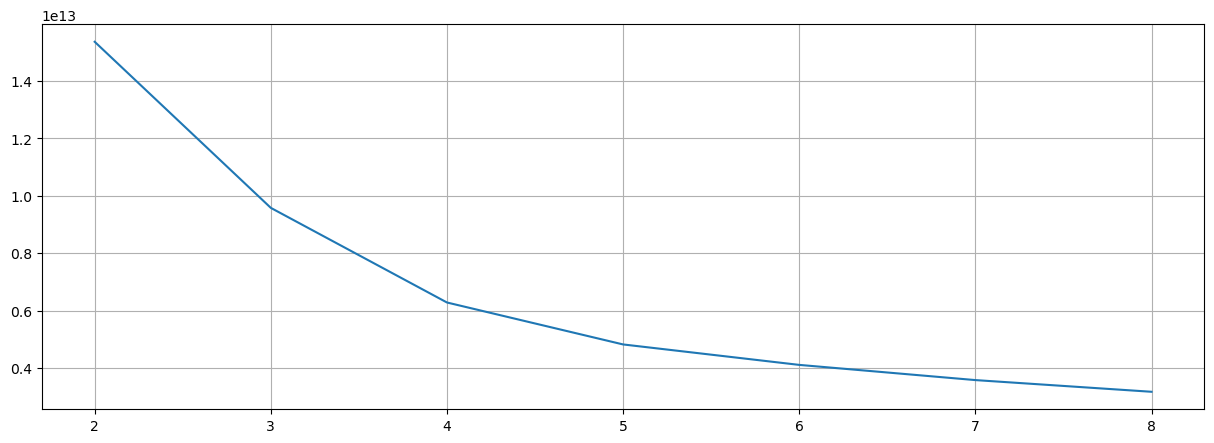

In [19]:
plt.figure(figsize=(15,5))
plt.plot(n_clusters,distortions)
plt.grid()
plt.show()

In [20]:
km  = KMeans(n_clusters=3,max_iter=10_000,n_init=100,random_state=42).fit(X)
X_t = km.fit_predict(X)
X_t


array([0, 2, 2, ..., 2, 0, 0])

# COMEÇANDO A CLUSTERIZAÇÃO

In [21]:
from sklearn.cluster import KMeans

In [22]:
df_d.dtypes

ID do Cliente                                                     float64
Preço de Venda (R$)                                               float64
Tipo de Cliente_b2b                                               float64
Tipo de Cliente_b2c                                               float64
Histórico de Aluguel (se aplicável)_nao                           float64
Histórico de Aluguel (se aplicável)_sim                           float64
Cancelamento da Venda_nao                                         float64
Cancelamento da Venda_sim                                         float64
Motivo do Cancelamento (se aplicável)_cliente desistiu            float64
Motivo do Cancelamento (se aplicável)_financiamento negado        float64
Motivo do Cancelamento (se aplicável)_problema na documentação    float64
dtype: object

In [23]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation only to 'preco venda' column, assuming its column name is 'preco venda'
df_d['Preço de Venda (R$)'] = np.log1p(df_d['Preço de Venda (R$)'])  # log1p handles zero values (log(1 + x))


In [24]:
X = df_d.div(df_d.sum(axis=1),axis="rows")
X 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_d)

In [25]:
X['Preço de Venda (R$)'].value_counts()

0.000241    3
0.000308    3
0.000173    3
0.000332    3
0.000403    2
           ..
0.000643    1
0.000784    1
0.000145    1
0.000148    1
0.000328    1
Name: Preço de Venda (R$), Length: 22789, dtype: int64

In [26]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

Cotovelo: Basicamente vamos traçar o grafico de cotovelo, que eh quanto os valores estao dispersos centroide, que é o centro do cluster

In [27]:
valores_k =[]
inercias = []

for  i in range(1,15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
    print(kmeans.inertia_)

2.091369916821446
0.6455442650613766
0.2856195866102333
0.17389535679916424
0.11497260564605552
0.0836750047041095
0.06536908124773871
0.047200909152817966
0.03755514720839751
0.030807347268332758
0.02631367397315694
0.02322457417182118
0.019615314493754043
0.01724407764593256


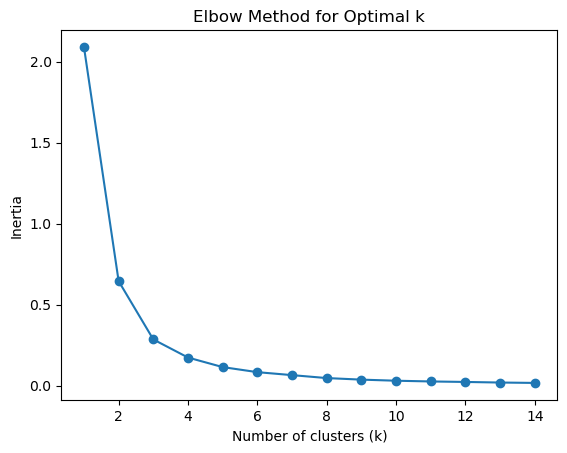

In [28]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Initialize lists to store the values of k and the corresponding inertias
valores_k = []
inercias = []

# Iterate over a range of cluster values (k) and compute inertia for each
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(X)
    valores_k.append(i)
    inercias.append(kmeans.inertia_)

# Plotting the elbow graph
plt.plot(valores_k, inercias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


Concluimos que o melhor numero de cluster é o 3, portanto, pois é o que possui a menor distância inercia, que é a distancia do centroide ao cluster.


Inertia in KMeans refers to the sum of squared distances from each data point to the centroid of the cluster it belongs to. It's a measure of how tightly the data points are grouped around the centroids.

A lower inertia means that the data points are closer to their respective centroids, which indicates tighter clusters.

The elbow graph helps us to check where the stepness of the graph is the lowest, because this will 

In [29]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)

In [30]:
df_d['Clusters'] = X_t
db_interesse['Clusters'] = X_t

In [31]:
import numpy as np

# Assuming db_interesse is the DataFrame with cluster information in the 'Clusters' column
df = db_interesse

# Loop through each column (excluding 'Clusters')
for col in df.drop('Clusters', axis=1).columns:
    # Loop through each unique cluster label
    for cl in np.sort(df['Clusters'].unique()):
        # Check if the column is categorical (object dtype)
        if df.dtypes[col] == object:
            # Calculate percentage value counts for each category in the current cluster
            vc = 100 * df.loc[df['Clusters'] == cl, col].value_counts() / (df['Clusters'] == cl).sum()
            for cat, cnt in vc.reset_index().values:
                print(f'Cluster {cl}: {col} - {cat}: {cnt:.2f}%')
        else:
            # For numerical columns, calculate the mean for the current cluster
            print(f'Cluster {cl}: {col} mean: {df.loc[df["Clusters"] == cl, col].mean():.2f}')

# Overall summary (all clusters)
for col in df.drop('Clusters', axis=1).columns:
    # Check if the column is categorical
    if df.dtypes[col] == object:
        # Calculate percentage value counts for all data
        vc = 100 * df[col].value_counts() / df.shape[0]
        for cat, cnt in vc.reset_index().values:
            print(f'All Clusters: {col} - {cat}: {cnt:.2f}%')
    else:
        # For numerical columns, calculate the overall mean
        print(f'All Clusters: {col} mean: {df[col].mean():.2f}')


Cluster 0: ID do Cliente mean: 41937.20
Cluster 1: ID do Cliente mean: 27347.39
Cluster 2: ID do Cliente mean: 73908.93
Cluster 0: Tipo de Cliente - b2c: 57.24%
Cluster 0: Tipo de Cliente - b2b: 42.76%
Cluster 1: Tipo de Cliente - b2c: 56.76%
Cluster 1: Tipo de Cliente - b2b: 43.24%
Cluster 2: Tipo de Cliente - b2b: 62.35%
Cluster 2: Tipo de Cliente - b2c: 37.65%
Cluster 0: Histórico de Aluguel (se aplicável) - nao: 75.62%
Cluster 0: Histórico de Aluguel (se aplicável) - sim: 24.38%
Cluster 1: Histórico de Aluguel (se aplicável) - nao: 74.63%
Cluster 1: Histórico de Aluguel (se aplicável) - sim: 25.37%
Cluster 2: Histórico de Aluguel (se aplicável) - nao: 75.02%
Cluster 2: Histórico de Aluguel (se aplicável) - sim: 24.98%
Cluster 0: Cancelamento da Venda - sim: 50.75%
Cluster 0: Cancelamento da Venda - nao: 49.25%
Cluster 1: Cancelamento da Venda - nao: 51.19%
Cluster 1: Cancelamento da Venda - sim: 48.81%
Cluster 2: Cancelamento da Venda - sim: 50.22%
Cluster 2: Cancelamento da Venda 

In [32]:
import pandas as pd

# Assuming df is your dataset containing cluster information
df = db_interesse  # Your dataset with clustering information

# Step 1: Aggregate metrics by cluster
cluster_summary = df.groupby('Clusters').agg(
    valor_médio_venda=('Preço de Venda (R$)', 'mean'),
    histórico_médio_aluguel=('Histórico de Aluguel (se aplicável)', lambda x: (x == 'sim').mean()),
    tipo_cliente_mais_comum=('Tipo de Cliente', lambda x: x.mode()[0]),
    quantidade_clientes=('Tipo de Cliente', 'count')  # Counting the number of clients using 'Tipo de Cliente'
).reset_index()

# Step 2: Identify the most valuable cluster
# Sorting by valor_médio_venda (sales price) and histórico_médio_aluguel (rental history)
cluster_valioso = cluster_summary.sort_values(
    ['valor_médio_venda', 'histórico_médio_aluguel'], ascending=False
).iloc[0]

# Step 3: Filter clients belonging to the most valuable cluster
clientes_valiosos = df[df['Clusters'] == cluster_valioso['Clusters']]

# Step 4: Display the results using standard print and pandas functions
print("Resumo dos Clusters:")
display(cluster_summary)
print("\nCluster mais valioso:")
display(cluster_valioso)

print("\nClientes mais valiosos (do cluster mais valioso):")
display(clientes_valiosos[
    ['Tipo de Cliente', 'Preço de Venda (R$)', 'Histórico de Aluguel (se aplicável)']
])

Resumo dos Clusters:


,Clusters,valor_médio_venda,histórico_médio_aluguel,tipo_cliente_mais_comum,quantidade_clientes
0,0,122048.174198,0.243762,b2c,6412
1,1,78943.345926,0.253654,b2c,8141
2,2,83821.634767,0.249823,b2b,8454



Cluster mais valioso:


Clusters                               0
valor_médio_venda          122048.174198
histórico_médio_aluguel         0.243762
tipo_cliente_mais_comum              b2c
quantidade_clientes                 6412
Name: 0, dtype: object


Clientes mais valiosos (do cluster mais valioso):


,Tipo de Cliente,Preço de Venda (R$),Histórico de Aluguel (se aplicável)
0,b2c,135375.00,nao
7,b2b,110263.78,nao
11,b2b,122175.94,nao
18,b2b,128606.25,sim
24,b2c,122175.94,sim
...,...,...,...
23015,b2c,99237.41,nao
23018,b2c,135375.00,nao
23019,b2c,116067.14,nao
23025,b2c,122175.94,nao


In [33]:
db_clusterizado = db_vendas

## Clusterização Recomeço

In [34]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregar o arquivo CSV de vendas
db_vendas = pd.read_csv('historico_vendas.csv', encoding='utf-8')

# Padronizar os nomes das colunas para facilitar a manipulação
db_vendas.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)

# **Selecionar as colunas relevantes para a clusterização**
vendas_filtered = db_vendas[['id_do_cliente', 'tipo_de_cliente', 
                             'histórico_de_aluguel_(se_aplicável)', 
                             'cancelamento_da_venda', 'preço_de_venda_(r$)']]

# **Pré-processamento**

# 1. Padronizar 'tipo_de_cliente' para lowercase e manter apenas 'b2b' e 'b2c'
vendas_filtered['tipo_de_cliente'] = vendas_filtered['tipo_de_cliente'].str.strip().str.lower()
vendas_filtered = vendas_filtered[vendas_filtered['tipo_de_cliente'].isin(['b2b', 'b2c'])]

# 2. Converter 'histórico_de_aluguel_(se_aplicável)' e 'cancelamento_da_venda' para binário (1/0)
for col in ['histórico_de_aluguel_(se_aplicável)', 'cancelamento_da_venda']:
    vendas_filtered[col] = (
        vendas_filtered[col].str.strip().str.lower()
        .replace({'sim': 1, 'não': 0, 'nao': 0, 'nÃo': 0, 'n':0})
        .fillna(0).astype(int)
    )

# 3. Remover símbolos de moeda e converter 'preço_de_venda_(r$)' para float
vendas_filtered['preço_de_venda_(r$)'] = (
    vendas_filtered['preço_de_venda_(r$)'].replace({'R\$': '', ',': ''}, regex=True).astype(float)
)

# **Escalar as colunas numéricas para a clusterização**
scaler = StandardScaler()
numeric_features = vendas_filtered[['histórico_de_aluguel_(se_aplicável)', 
                                    'cancelamento_da_venda', 
                                    'preço_de_venda_(r$)']]
scaled_features = scaler.fit_transform(numeric_features)

# **Aplicar o KMeans com 3 clusters**
kmeans = KMeans(n_clusters=3, random_state=42)
vendas_filtered['cluster'] = kmeans.fit_predict(scaled_features)

# **Adicionar a coluna 'cluster' ao dataset original**
# Usamos merge para garantir que os clusters sejam atribuídos corretamente por ID
db_vendas = db_vendas.merge(
    vendas_filtered[['id_do_cliente', 'cluster']], on='id_do_cliente', how='left'
)

# **Exibir resumo dos clusters**
cluster_summary = vendas_filtered.groupby('cluster').agg(
    preço_médio=('preço_de_venda_(r$)', 'mean'),
    aluguel_médio=('histórico_de_aluguel_(se_aplicável)', 'mean'),
    cancelamento_médio=('cancelamento_da_venda', 'mean'),
    tipo_cliente_mais_comum=('tipo_de_cliente', lambda x: x.mode()[0]),
    quantidade=('id_do_cliente', 'count')
).reset_index()

# **Identificar o cluster mais valioso** (maior preço médio de venda)
cluster_valioso = cluster_summary.sort_values(
    'preço_médio', ascending=False
).iloc[0]

# **Filtrar clientes do cluster mais valioso**
clientes_valiosos = vendas_filtered[vendas_filtered['cluster'] == cluster_valioso['cluster']]

# **Exibir resultados**
print("Resumo dos Clusters:")
print(cluster_summary)
print("\nCluster mais valioso:")
print(cluster_valioso)

print("\nClientes mais valiosos (do cluster mais valioso):")
print(clientes_valiosos[['id_do_cliente', 'tipo_de_cliente', 'preço_de_venda_(r$)']])


C:\Users\rique\AppData\Local\Temp\ipykernel_5844\1674512601.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vendas_filtered['tipo_de_cliente'] = vendas_filtered['tipo_de_cliente'].str.strip().str.lower()


Resumo dos Clusters:
   cluster   preço_médio  aluguel_médio  cancelamento_médio  \
0        0  93137.926698            0.0            1.000000   
1        1  92539.258702            0.0            0.000000   
2        2  92486.760463            1.0            0.506272   

  tipo_cliente_mais_comum  quantidade  
0                     b2c        8568  
1                     b2b        8699  
2                     b2c        5740  

Cluster mais valioso:
cluster                               0
preço_médio                93137.926698
aluguel_médio                       0.0
cancelamento_médio                  1.0
tipo_cliente_mais_comum             b2c
quantidade                         8568
Name: 0, dtype: object

Clientes mais valiosos (do cluster mais valioso):
       id_do_cliente tipo_de_cliente  preço_de_venda_(r$)
2            60203.0             b2c             89561.76
5            82476.0             b2c             65836.12
7            16863.0             b2b            110263.

In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

silhouette_score(scaled_features, kmeans.fit_predict(scaled_features))

0.48749531616938563

In [36]:
db_vendas

,id_do_cliente,tipo_de_cliente,data_da_venda,id_do_carro_vendido,marca_do_carro,ano_de_fabricação_do_carro,quilometragem_do_carro_no_momento_da_venda,tipo_de_combustível,tipo_de_transmissão,preço_de_venda_(r$),forma_de_pagamento,status_do_pagamento,histórico_de_aluguel_(se_aplicável),id_do_contrato_de_aluguel_anterior_(se_aplicável),desconto_para_ex-cliente_de_aluguel_(%),cancelamento_da_venda,motivo_do_cancelamento_(se_aplicável),coerente,cluster
0,67593.0,b2c,13/05/2023,516713.0,voLKSWAGEn,2022.0,37656.0,HÍbridO,aUTOmÁTIcA,135375.00,TRanSfeRênCIA BanCáRIa,comPLETO,NÃo,NaN,0.0,NÃo,NaN,True,1.0
1,67593.0,b2c,13/05/2023,516713.0,voLKSWAGEn,2022.0,37656.0,HÍbridO,aUTOmÁTIcA,135375.00,TRanSfeRênCIA BanCáRIa,comPLETO,NÃo,NaN,0.0,NÃo,NaN,True,1.0
2,88684.0,B2b,03 de March de 2022,562471.0,cHEvRoLET,2013.0,214637.0,gaSoLIna,AuTomÁtICa,72948.61,FiNaNCIAmeNTo,EM AndamenTo,nãO,NaN,0.0,Não,NaN,True,1.0
3,60203.0,b2c,13/02/2023,367386.0,voLkSWaGEN,2016.0,134394.0,HÍBRiDO,AutoMáTIcA,89561.76,FInAncIAmEnto,em ANdAMEntO,nÃO,NaN,0.0,siM,FiNaNciAMEnTO NEgadO,True,0.0
4,40452.0,B2C,03 de August de 2023,126368.0,chEVrolet,2013.0,194853.0,híBrIDo,aUTOMÁticA,76788.01,TransFErência bANcÁRIa,cOmpLEto,NÃo,NaN,0.0,Não,NaN,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29218,68382.0,b2B,13/01/2022,656794.0,hoNDA,2011.0,235990.0,eLéTrICO,AUTOMáTiCA,65836.12,CarTão DE crÉDITO,COmpleTo,nÃO,NaN,0.0,siM,fInanCIamEnTo NEgAdO,True,0.0
29219,75453.0,b2b,05/07/2024,962991.0,hOndA,2012.0,183062.0,elÉtrico,mAnuAL,69301.18,fInaNciameNTO,EM aNDAmento,sIm,48905.0,15.0,sIm,pROBlEma NA dOCuMentaçÃO,True,2.0
29220,86179.0,b2b,17/02/2023,897696.0,TOyoTa,2017.0,106362.0,GAsOliNa,AuTOMáTICA,89561.76,fInAnciAMento,EM AndamEnTO,NÃO,NaN,0.0,sim,cLiEnTe Desistiu,True,0.0
29221,51205.0,b2C,01/07/2024,119376.0,foRd,2020.0,68167.0,diESeL,ManUaL,122175.94,fINAncIAMentO,EM AndaMENto,NÃO,NaN,0.0,NaO,NaN,True,1.0


In [37]:
db_alterado = db_vendas.copy()

In [38]:
db_alterado.dropna(how='all', inplace=True)

db_alterado['data_da_venda'].dtype #ou seja eh uma string 

data_venda = db_alterado['data_da_venda']


def convert_to_month_year(date_str):
    if isinstance(date_str, str):
        # First, check if the date is already in the yyyy-mm-dd format
        if re.match(r'\d{4}-\d{2}-\d{2}', date_str):
            return pd.to_datetime(date_str).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Check for the dd/mm/yyyy format
        elif re.match(r'\d{2}/\d{2}/\d{4}', date_str):
            return pd.to_datetime(date_str, dayfirst=True).strftime('%Y-%m')  # Convert and format as Year-Month
        
        # Handle verbose format like '03 de August de 2023'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            # Mapping Portuguese/English month names to their corresponding numbers
            months_mapping = {
                'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
                'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
                'november': '11', 'december': '12',
                'janeiro': '01', 'fevereiro': '02', 'março': '03', 'abril': '04', 'maio': '05',
                'junho': '06', 'julho': '07', 'agosto': '08', 'setembro': '09', 'outubro': '10',
                'novembro': '11', 'dezembro': '12'
            }
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                # Return in Year-Month format
                return f'{year}-{month_num}'


db_alterado['data_da_venda'] = data_venda.apply(convert_to_month_year)


db_alterado['ano_de_fabricação_do_carro'] = db_alterado['ano_de_fabricação_do_carro'].astype(int)


db_alterado = db_alterado.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)

db_alterado = db_alterado.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)



db_alterado['tipo_de_combustível'] = db_alterado['tipo_de_combustível'].replace({
    'elétrico': 'eletrico',
    'híbrido': 'hibrido'
})

db_alterado['forma_de_pagamento'] = db_alterado['forma_de_pagamento'].replace({
    'cartao de crédito': 'cartao de credito',
    'cartão de credito': 'cartao de credito',
    'cartão de crédito': 'cartao de credito',
    'transferência bancária' : 'transferencia bancaria'
})

db_alterado['histórico_de_aluguel_(se_aplicável)'] = db_alterado['histórico_de_aluguel_(se_aplicável)'].replace({
    'n': 'nao',
    'não': 'nao'
})

db_alterado['cancelamento_da_venda'] = db_alterado['cancelamento_da_venda'].replace({
    'n': 'nao',
    'não':'nao'
})

db_alterado['motivo_do_cancelamento_(se_aplicável)'] = db_alterado['motivo_do_cancelamento_(se_aplicável)'].replace({
    'problema na documentaçao': 'problema na documentação'
})

#db_alterado["Cancelamento da Venda"] = db_alterado.loc[db_alterado["Cancelamento da Venda"] != "sim", "Cancelamento da Venda"]

#db_alterado.dropna(subset=["Cancelamento da Venda"], inplace=True)


In [39]:
db_alterado

,id_do_cliente,tipo_de_cliente,data_da_venda,id_do_carro_vendido,marca_do_carro,ano_de_fabricação_do_carro,quilometragem_do_carro_no_momento_da_venda,tipo_de_combustível,tipo_de_transmissão,preço_de_venda_(r$),forma_de_pagamento,status_do_pagamento,histórico_de_aluguel_(se_aplicável),id_do_contrato_de_aluguel_anterior_(se_aplicável),desconto_para_ex-cliente_de_aluguel_(%),cancelamento_da_venda,motivo_do_cancelamento_(se_aplicável),coerente,cluster
0,67593.0,b2c,2023-05,516713.0,volkswagen,2022,37656.0,hibrido,automática,135375.00,transferencia bancaria,completo,nao,NaN,0.0,nao,NaN,True,1.0
1,67593.0,b2c,2023-05,516713.0,volkswagen,2022,37656.0,hibrido,automática,135375.00,transferencia bancaria,completo,nao,NaN,0.0,nao,NaN,True,1.0
2,88684.0,b2b,2022-03,562471.0,chevrolet,2013,214637.0,gasolina,automática,72948.61,financiamento,em andamento,nao,NaN,0.0,nao,NaN,True,1.0
3,60203.0,b2c,2023-02,367386.0,volkswagen,2016,134394.0,hibrido,automática,89561.76,financiamento,em andamento,nao,NaN,0.0,sim,financiamento negado,True,0.0
4,40452.0,b2c,2023-08,126368.0,chevrolet,2013,194853.0,hibrido,automática,76788.01,transferencia bancaria,completo,nao,NaN,0.0,nao,NaN,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29218,68382.0,b2b,2022-01,656794.0,honda,2011,235990.0,eletrico,automática,65836.12,cartao de credito,completo,nao,NaN,0.0,sim,financiamento negado,True,0.0
29219,75453.0,b2b,2024-07,962991.0,honda,2012,183062.0,eletrico,manual,69301.18,financiamento,em andamento,sim,48905.0,15.0,sim,problema na documentação,True,2.0
29220,86179.0,b2b,2023-02,897696.0,toyota,2017,106362.0,gasolina,automática,89561.76,financiamento,em andamento,nao,NaN,0.0,sim,cliente desistiu,True,0.0
29221,51205.0,b2c,2024-07,119376.0,ford,2020,68167.0,diesel,manual,122175.94,financiamento,em andamento,nao,NaN,0.0,nao,NaN,True,1.0


In [40]:
db_vendas.columns

Index(['id_do_cliente', 'tipo_de_cliente', 'data_da_venda',
       'id_do_carro_vendido', 'marca_do_carro', 'ano_de_fabricação_do_carro',
       'quilometragem_do_carro_no_momento_da_venda', 'tipo_de_combustível',
       'tipo_de_transmissão', 'preço_de_venda_(r$)', 'forma_de_pagamento',
       'status_do_pagamento', 'histórico_de_aluguel_(se_aplicável)',
       'id_do_contrato_de_aluguel_anterior_(se_aplicável)',
       'desconto_para_ex-cliente_de_aluguel_(%)', 'cancelamento_da_venda',
       'motivo_do_cancelamento_(se_aplicável)', 'coerente', 'cluster'],
      dtype='object')

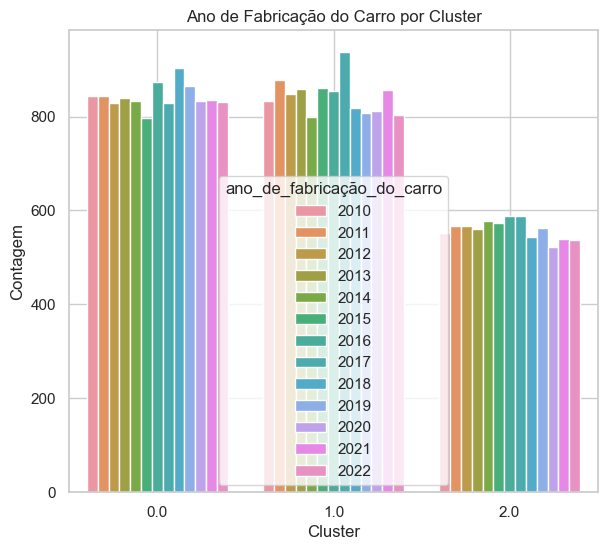

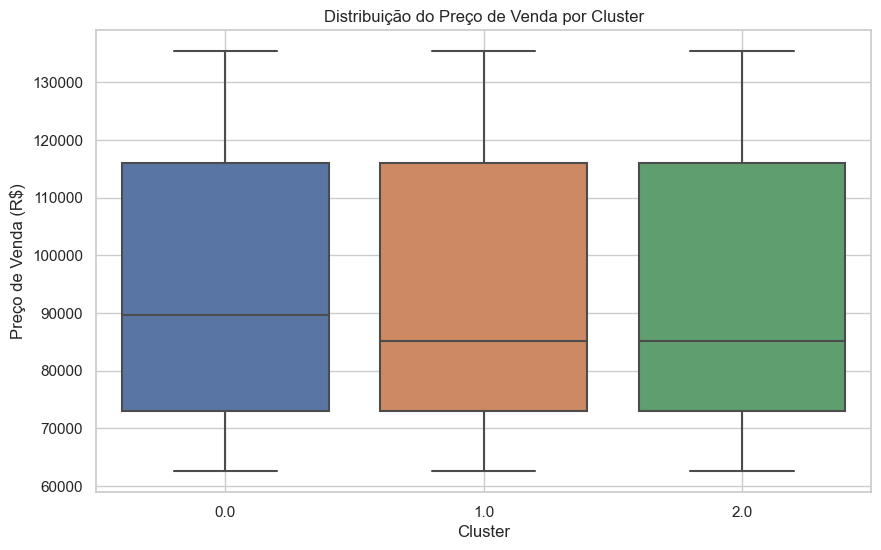

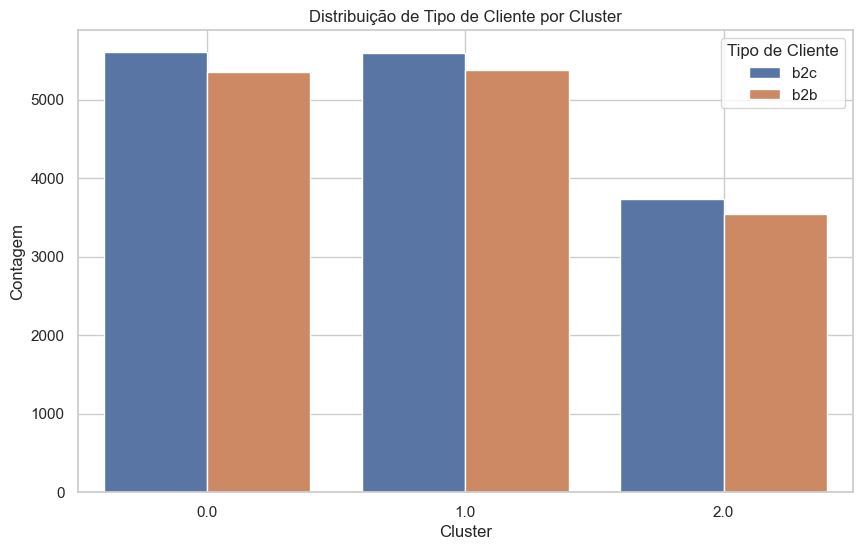

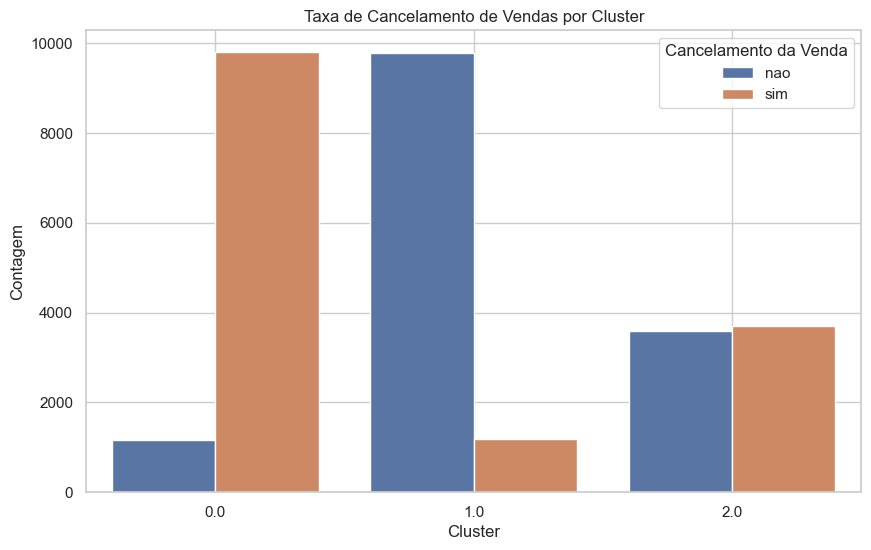

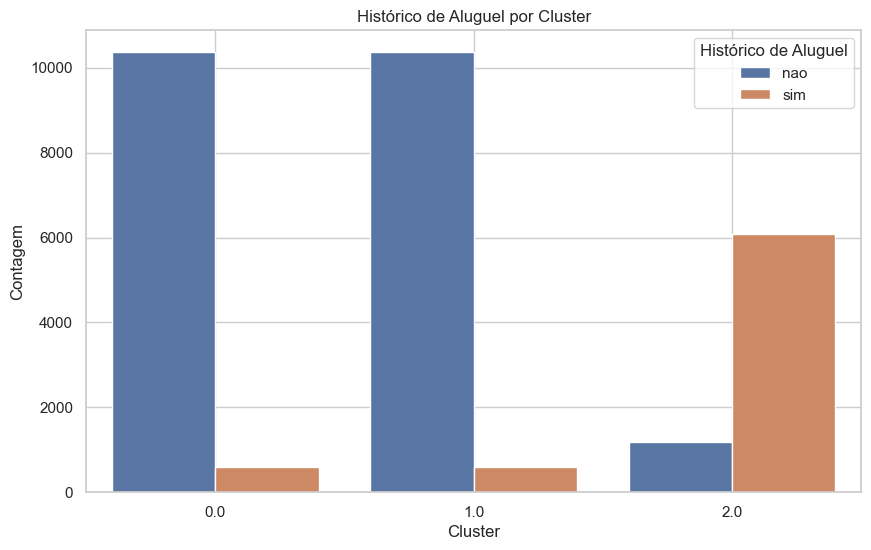

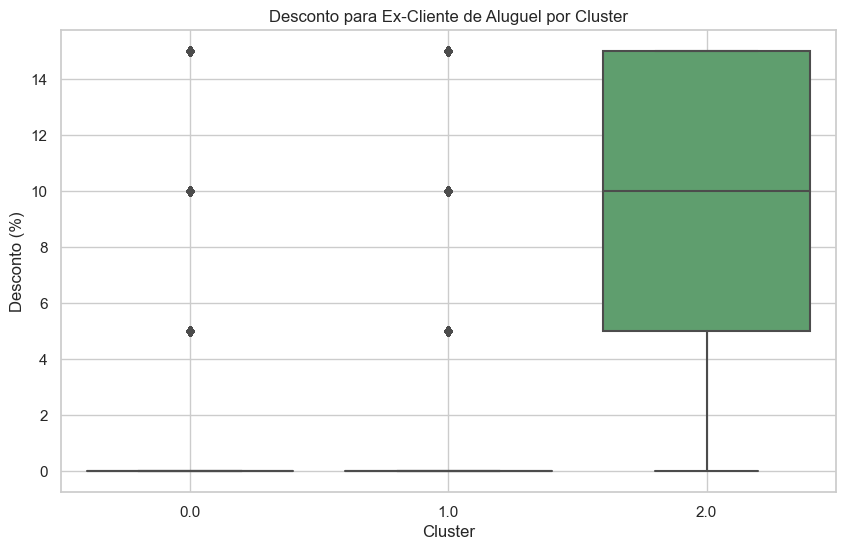

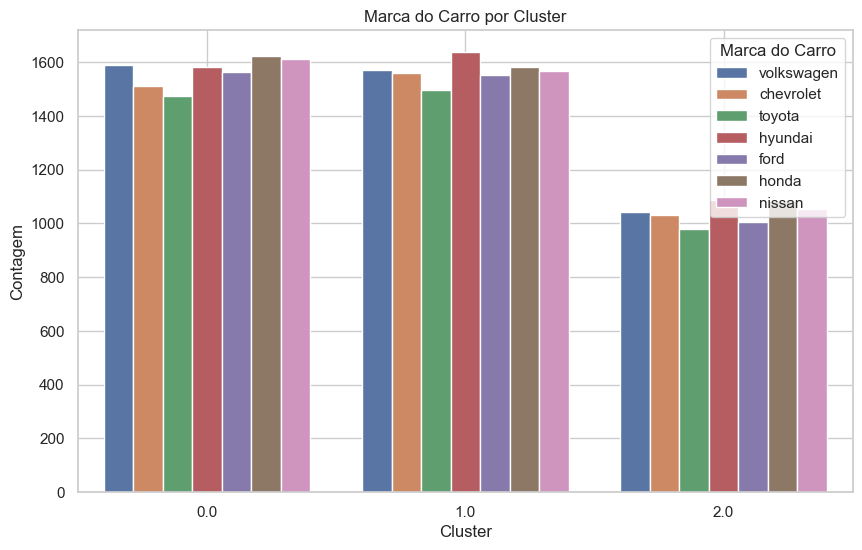

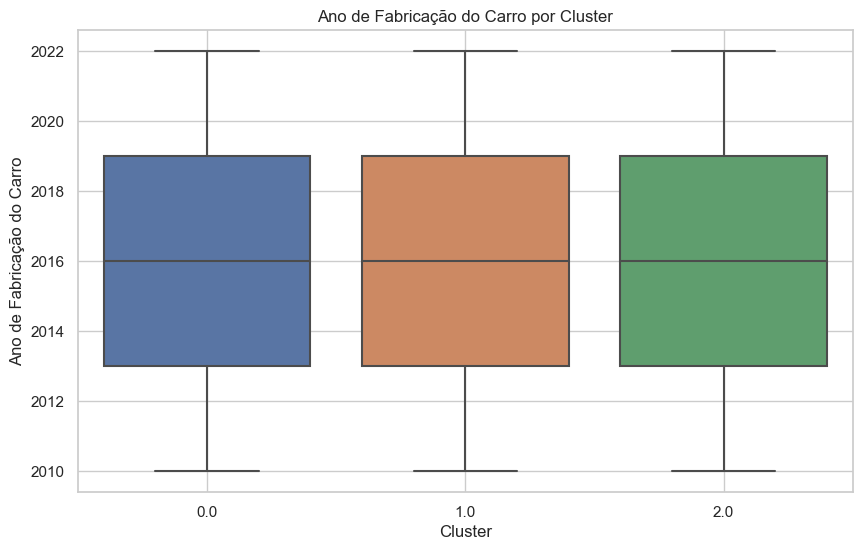

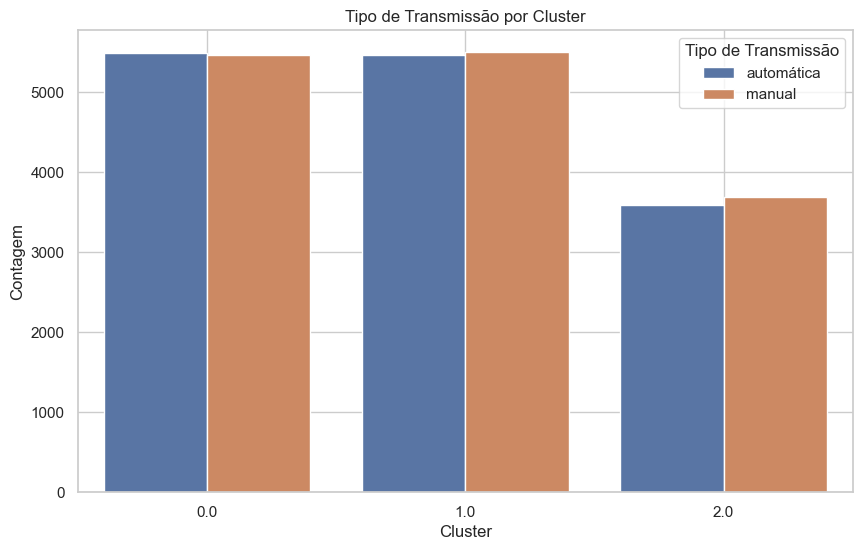

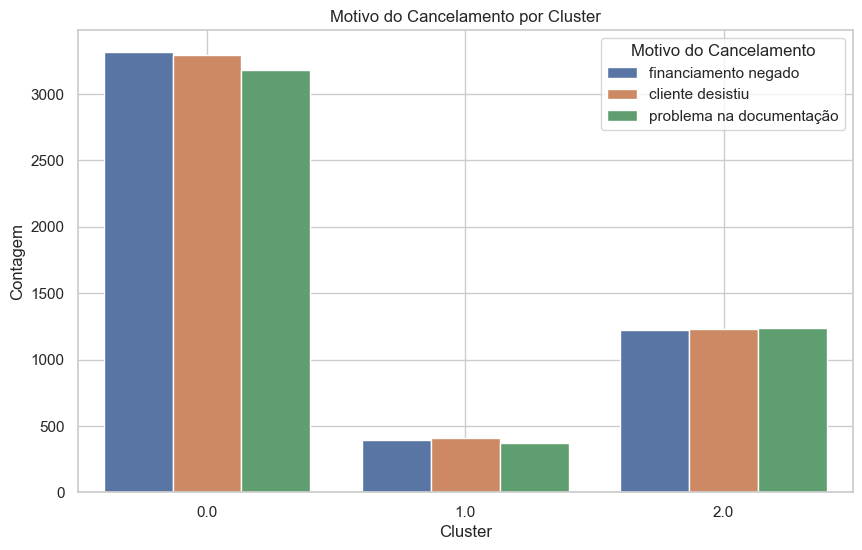

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar a base com a coluna cluster
#db_alterado_com_cluster = pd.read_csv('db_alterado_com_cluster.csv', encoding='utf-8')

# Definir estilo dos gráficos
sns.set(style='whitegrid')

# Gráfico do ano de fabricação do carro por cluster em porcentagem, e printar um gráfico do lado do outro
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=db_alterado, x='cluster', hue='ano_de_fabricação_do_carro')
plt.title('Ano de Fabricação do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.grid(True)

# 1. Distribuição do Preço de Venda por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_alterado, x='cluster', y='preço_de_venda_(r$)')
plt.title('Distribuição do Preço de Venda por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Preço de Venda (R$)')
plt.grid(True)
plt.show()

# 2. Tipo de Cliente por Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='tipo_de_cliente')
plt.title('Distribuição de Tipo de Cliente por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Tipo de Cliente', loc='upper right')
plt.grid(True)
plt.show()

# 3. Taxa de Cancelamento de Vendas por Cluster (em porcentagem)
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='cancelamento_da_venda')
plt.title('Taxa de Cancelamento de Vendas por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Cancelamento da Venda', loc='upper right')
plt.grid(True)
plt.show()

# 4. Histórico de Aluguel por Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='histórico_de_aluguel_(se_aplicável)')
plt.title('Histórico de Aluguel por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Histórico de Aluguel', loc='upper right')
plt.grid(True)
plt.show()

# 5. Desconto para Ex-Cliente de Aluguel por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_alterado, x='cluster', y='desconto_para_ex-cliente_de_aluguel_(%)')
plt.title('Desconto para Ex-Cliente de Aluguel por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Desconto (%)')
plt.grid(True)
plt.show()

# 6. Marca do Carro por Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='marca_do_carro')
plt.title('Marca do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Marca do Carro', loc='upper right')
plt.grid(True)
plt.show()

# 7. Ano de Fabricação do Carro por Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=db_alterado, x='cluster', y='ano_de_fabricação_do_carro')
plt.title('Ano de Fabricação do Carro por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Ano de Fabricação do Carro')
plt.grid(True)
plt.show()

# 8. Tipo de transmissao por Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='tipo_de_transmissão')
plt.title('Tipo de Transmissão por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Tipo de Transmissão', loc='upper right')
plt.grid(True)
plt.show()

# 10. Motivo do Cancelamento por Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=db_alterado, x='cluster', hue='motivo_do_cancelamento_(se_aplicável)')
plt.title('Motivo do Cancelamento por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.legend(title='Motivo do Cancelamento', loc='upper right')
plt.grid(True)
plt.show()



